<h1 align=center><font size=5>Digit Recognition. CNN in PyTorch. </font></h1>

In [1]:
#Needed libraries and modules
import pandas as pd                                  # data processing, reading CSV file, dealing with dataframes etc
import numpy as np                                   # linear algebra functionalities 
import matplotlib.pyplot as plt                      # visualization library

#Modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

import math 
import time
import multiprocessing
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
from torchvision import transforms


### Table of Contents

* [1. Loading Data](#Section1)
    * [1.1 From cvs files to dataframes](#SubSection_1_1)
    * [1.2 Dataset class and transforms](#SubSection_1_2)
    * [1.3 Train and validation sets. Visualization](#SubSection_1_3)
* [2. CNN with Batch Normalization](#Section2)
* [3. Training the model](#Section3)
* [4 Analyzing results](#Section_4)
* [5 Predictions on test set](#Section_5)

 # 1. Loading Data <a class="anchor" id="Section1"></a>

We want to be able to train our model on a hardware accelerator like the GPU, 
if it is available. Let's check to see if 
"torch.cuda" <https://pytorch.org/docs/stable/notes/cuda.html> is available, else we 
continue to use the CPU. 

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


### 1.1 Loading data from cvs files into data frames<a class="anchor" id="SubSection_1_1"></a> 

In [4]:
#Loading training and test set to dataframes
path_train = 'train.csv'
path_test = 'test.csv'

df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

In [5]:
df_train.head()

label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

We convert the data to numpy. We normalize the data to avoid the vanishing gradient problem when training without usign batchnormalzation

In [6]:
#Training data
X = df_train.iloc[:, 1:].to_numpy() /255
Y = df_train.iloc[:, 0].to_numpy()

#Train set & validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=1)

#Test set 
X_test = df_test.to_numpy() / 255


In [7]:
print('Shape of train dataset: ', X_train.shape)
print('Shape of validation dataset: ', X_val.shape)
print('Shape of test dataset: ', X_test.shape)

Shape of train dataset:  (37800, 784)
Shape of validation dataset:  (4200, 784)
Shape of test dataset:  (28000, 784)


### 1.2 Dataset class and transforms<a class="anchor" id="SubSection_1_2"></a> 

Datset class

In [8]:
class Dataset(Dataset):
    
    def __init__(self, x, y = None, transform = None):
        self.x = x
        self.y = y
        self.transform = transform
        self.lenght = self.x.shape[0]
        
    def __len__(self):
        return self.lenght
    
    def __getitem__(self, idx):
        image = self.x[idx, :]
        if self.transform:
            image = self.transform(image)
        label = int(self.y[idx])
        return image, label

Transforms

In [9]:
class Numpy_to_ImageTensor_Reshape(object):
    '''
    This is a transform object, that transforms a given numpy array into a tensor with dimensions especified by dims.
    '''
    # Constructor
    def __init__(self, dims):
        self.dims = dims
        
    # Executor
    def __call__(self, sample):
        image = torch.from_numpy(sample).type(torch.FloatTensor)
        image = image.view(1,self.dims[0], self.dims[1])
        return image

In [10]:
IMAGE_SIZE = 28
composed = transforms.Compose([Numpy_to_ImageTensor_Reshape([28,28]), transforms.Resize((IMAGE_SIZE,IMAGE_SIZE))])

Train and test set

In [11]:
train_set = Dataset(x=X_train, y=Y_train, transform=composed)

In [12]:
validation_set = Dataset(x=X_val, y=Y_val, transform=composed)

In [13]:
print('Size of train set: ', len(train_set))
print('Size of validation set: ', len(validation_set))

Size of train set:  37800
Size of validation set:  4200


Function to print images:

In [14]:
def show_data(data_sample):
    plt.imshow(data_sample[0].view(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

In [15]:
show_data(train_set[9])

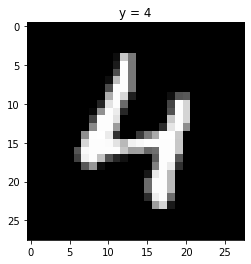

In [16]:
show_data(validation_set[156])

 # 2. CNN with Batch Normalization <a class="anchor" id="Section2"></a>

In [17]:
class CNN_BatchNorm(nn.Module):
     
    # Contructor
    def __init__(self, Conv_Layers, FC_Layers, BatchNorm = False):
        super(CNN_BatchNorm, self).__init__()
        
        self.Conv = nn.ModuleList()
        self.FC = nn.ModuleList()
        
        #Building convolution layers
        for layer in Conv_Layers:
            conv = nn.Conv2d(in_channels=layer[0], out_channels=layer[1], kernel_size=layer[2], 
                             stride= layer[3], padding=layer[4])
            maxpool = nn.MaxPool2d(kernel_size=layer[5])
            
            #Adding the components o fhte layers (convolution, activation, maxpooling) to self.Conv
            self.Conv.append(conv)
            if BatchNorm: 
                self.Conv.append(nn.BatchNorm2d(layer[1]))
            self.Conv.append(nn.ReLU())
            self.Conv.append(maxpool)
            
        #Building Fully connected layers
        L = len(FC_Layers)
        for i in range(L-1):
            input_size = FC_Layers[i]
            output_size = FC_Layers[i+1]
            self.FC.append(nn.Linear(input_size, output_size))
            if BatchNorm:
                self.FC.append(nn.BatchNorm1d(output_size))
            if i < L-2:
                self.FC.append(nn.ReLU())
            
    #Prediction
    def forward(self, x):
        #Convolutional layers:
        for module in self.Conv:
            x = module(x)
            
        #Flattening
        x = x.view(x.size(0), -1)
       
        #Fully connected layers
        for transform in self.FC:
            x = transform(x)
        return x

 # 3. Training the model <a class="anchor" id="Section3"></a>

Function to train the model

In [18]:
def train_model(model, train_loader, validation_loader, optimizer, criterion=nn.CrossEntropyLoss(), n_epochs=4):
    #global variable 
    N_test=len(validation_set)
    
    accuracy_list=[]
    loss_list=[]
    
    for epoch in range(n_epochs):
        #Training
        COST = 0
        model.train()   #batch normalization in training mode
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            COST += loss.data
        loss_list.append(COST)
        
        #Validating
        correct=0
        model.eval()    #batch normalization in validation mode
        for x_test, y_test in validation_loader:
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
     
    return accuracy_list, loss_list

We will now do a grid search looking for good parameters of the convolution kernel_size in the model and for the momentum parameter in the GD algorithm. 

We will always use 2 convolutional layers and one fully connected layer. The general configuration is as follows:

* 1st convolutional layer: [in_channels = 1, out_channels = 16, convolution_kernel_size = 2*n+1, stride= 1, padding = n, maxpool__kernel_size =2]
* 1st convolutional layer: [in_channels = 16, out_channels = 32, convolution_kernel_size = 2*n+1, stride= 1, padding = n, maxpool__kernel_size =2]
* Fully connected layer: [32 * 7 * 7,10]

Let's now define the fnction for grid search


In [19]:
def GridSearch(ker_size_list = [5], momentum_list = [0]):
    Results = {}
    Best_accuracy = 0
    Best_model = None
    Best_parameters = {'kernel_size': None, 'momentum': None}
    
    for k in ker_size_list:
        for momentum in momentum_list:
            model = CNN_BatchNorm([[1,16,2*k+1,1,k,2], [16,32,2*k+1,1,k,2]], [32*7*7,10], BatchNorm = True)
            model.to(device)
            learning_rate = 0.10
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
            Results["K_"+str(k)+" & M_"+str(momentum)] = train_model(model=model, train_loader=train_loader,
                                                                   validation_loader=validation_loader, 
                                                                   optimizer=optimizer, n_epochs=n_epochs)
            if Best_accuracy < Results["K_"+str(k)+" & M_"+str(momentum)][0][n_epochs-1]: 
                Best_accuracy = Results["K_"+str(k)+" & M_"+str(momentum)][0][n_epochs-1]
                Best_model = model
                Best_parameters['kernel_size'] = k
                Best_parameters['momentum'] = momentum
    
    return Best_accuracy, Best_parameters, Best_model, Results

Loss function and data loaders

In [20]:
criterion = nn.CrossEntropyLoss()
n_epochs=30
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_set, batch_size=5000)

GridSearch

In [21]:
%%time
ker_size_list = [5, 6]
momentum_list = [0.0, 0.5, 0.8]

Best_accuracy, Best_parameters, Best_model, Results = GridSearch(ker_size_list = ker_size_list,
                                                               momentum_list = momentum_list)

CPU times: user 2h 16min 34s, sys: 7min 15s, total: 2h 23min 50s
Wall time: 1h 55min 5s


In [22]:
print('Best accuracy: ', Best_accuracy)
print('Best parameters: ', Best_parameters)
print('Best model: \n', Best_parameters)

Best accuracy:  0.9923809523809524
Best parameters:  {'kernel_size': 6, 'momentum': 0.5}
Best model: 
 {'kernel_size': 6, 'momentum': 0.5}


 # 4. Analizing results <a class="anchor" id="Section4"></a>

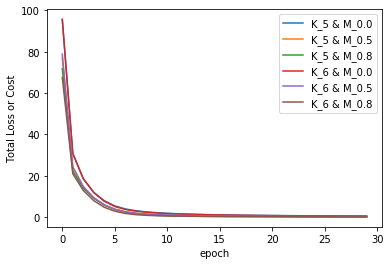

In [23]:
# Plot the Loss result for each term

for key, value in Results.items():
    plt.plot(value[1],label=key)
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('Total Loss or Cost')

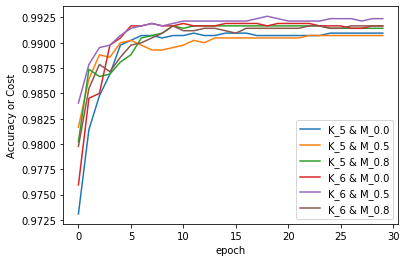

In [24]:
# Plot the Loss result for each term

for key, value in Results.items():
    plt.plot(value[0],label=key)
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('Accuracy or Cost')

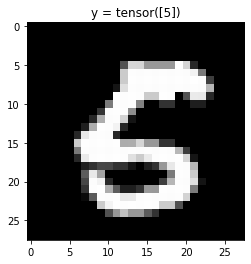

yhat:  tensor([6])


yhat:  tensor([7])


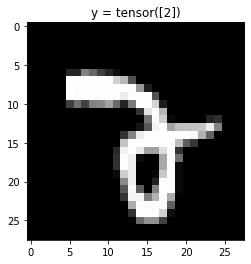

yhat:  tensor([7])


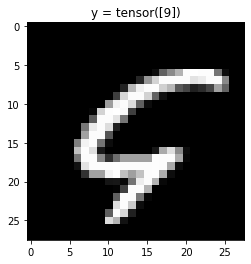

yhat:  tensor([5])


yhat:  tensor([6])


In [25]:
# Plot the mis-classified samples

count = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_set, batch_size=1):
    z = Best_model(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat: ",yhat)
        count += 1
    if count >= 5:
        break  

 # 5. Predictions on the test set <a class="anchor" id="Section5"></a>

In [26]:
#Test set 
X_test = df_test.to_numpy() / 255

X_test = torch.from_numpy(X_test).type(torch.FloatTensor).view(-1,1,28,28)
z = Best_model(X_test)
_, yhat_test = torch.max(z, 1)
yhat_test

tensor([2, 0, 9,  ..., 3, 9, 2])

In [29]:

path_test_labels = 'test_labels.csv'
df_test_lables = pd.read_csv(path_test_labels)
y_test = torch.from_numpy(df_test_lables['Label'].to_numpy())
correct = (yhat_test == y_test).sum().item()
N_test = yhat_test.size()[0]
accuracy = correct / N_test
accuracy

0.9911785714285715